In [1]:
import pandas as pd


## Conceptual model:

<img src = "4142DIAGRAM.png" style ="width: 800px">

# Data Staging: 
## Extract, Transform and Load (ETL)

Extracting data

In [2]:
df = pd.read_csv('./healthcare-dataset-stroke-data.csv')


Updating column names to to ensure uniformity 

In [3]:
df = df.rename({'Residence_type': 'residence_type'}, axis='columns')
df = df.replace({'formerly smoked': 'Formerly smoked',
                'never smoked': 'Never smoked', 'smokes': 'Smokes', 'children': 'Children'})


Dropping missing values

In [4]:
df = df.dropna()


Ensuring missing values have been dropped

In [5]:
df.isnull().sum()


id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

## Binning Data 

Starting with binning age group

In [6]:
df['age_group'] = pd.cut(df['age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], right=False, labels=[
                         '0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+'])


Binning BMI

In [7]:
df['bmi_category'] = pd.cut(df['bmi'], bins=[0, 18.5, 25, 30, 40, 100], right=False, labels=[
                            'Underweight', 'Normal weight', 'Obese class I', 'Obese class II', 'Morbidly obese'])


Binning glucose

In [8]:
df['glucose_range'] = pd.cut(df['avg_glucose_level'], bins=[
                             0, 200, 500], right=False, labels=['Non-diabetic', 'Diabetic'])


Binning smoking status

In [9]:
# df['ever_smoked'] = df['smoking_status']

df['ever_smoked'] = df['smoking_status'].replace(
    {'Formerly smoked': 'Yes', 'Never smoked': 'No', 'Smokes': 'Yes', 'Children': 'No'})


Binning number of risk factors each person has (glucose_range, smoked, bmi, hypertension, heart disease)

In [10]:
def riskChecker(x):
    counter = 0
    tmpHypertension = x.hypertension
    tmpHeartDisease = x.heart_disease
    tmpBMI = x.bmi_category
    tmpGlucose = x.glucose_range
    tmpSmoked = x.ever_smoked
    if tmpHypertension == 1:
        counter += 1
    if tmpHeartDisease == 1:
        counter += 1
    if tmpBMI == 'Obese class I' or tmpBMI == 'Obese class II' or tmpBMI == 'Morbidly obese':
        counter += 1
    if tmpGlucose == 'Diabetic':
        counter += 1
    if tmpSmoked == x.ever_smoked == 'Yes':
        counter += 1

    return counter


In [11]:
df['risk_factor_count'] = df.apply(riskChecker, axis=1)


Generating Surrogate Keys

In [12]:
df['surr_key'] = range(1, len(df)+1)


# Export to csv cleaned data

In [13]:
df.to_csv('./clean_stroke_data.csv')


# Creating and Inputting into DB

In [14]:
fact_table_dataframe = pd.DataFrame(df,
                                    columns=['surr_key', 'demo_key', 'health_key', 'personal_key', 'age', 'bmi', 'risk_factor_count', 'stroke'])
personal_attribute_table = pd.DataFrame(df,
                                        columns=['surr_key', 'gender', 'age'])
demographic_info_table = pd.DataFrame(df,
                                      columns=['surr_key', 'ever_married', 'work_type', 'residence_type'])
health_attribute_table = pd.DataFrame(df,
                                      columns=['surr_key', 'hypertension', 'heart_disease', 'smoking_status',
                                               'avg_glucose_level', 'bmi'])


In [15]:
fact_table_dataframe['demo_key'] = fact_table_dataframe['surr_key']
fact_table_dataframe['health_key'] = fact_table_dataframe['surr_key']
fact_table_dataframe['personal_key'] = fact_table_dataframe['surr_key']
fact_table_dataframe = fact_table_dataframe.drop('surr_key', axis=1)

personal_attribute_table = personal_attribute_table.rename(
    {'surr_key': 'personal_key'}, axis='columns')
demographic_info_table = demographic_info_table.rename(
    {'surr_key': 'demo_key'}, axis='columns')
health_attribute_table = health_attribute_table.rename(
    {'surr_key': 'health_key'}, axis='columns')

fact_table_cols = ",".join([str(i)
                           for i in fact_table_dataframe.columns.tolist()])
personal_attribute_cols = ",".join(
    [str(i) for i in personal_attribute_table.columns.tolist()])
demographic_info_cols = ",".join(
    [str(i) for i in demographic_info_table.columns.tolist()])
health_attribute_cols = ",".join(
    [str(i) for i in health_attribute_table.columns.tolist()])


In [16]:
from configparser import ConfigParser
import psycopg2
from typing import Dict


def load_connection_info(
    ini_filename: str
) -> Dict[str, str]:
    parser = ConfigParser()
    parser.read(ini_filename)
    # Create a dictionary of the variables stored under the "postgresql" section of the .ini
    conn_info = {param[0]: param[1] for param in parser.items("postgresql")}
    return conn_info


def create_db(
    conn_info: Dict[str, str],
) -> None:
    # Connect just to PostgreSQL with the user loaded from the .ini file
    psql_connection_string = f"user={conn_info['user']} password={conn_info['password']}"
    conn = psycopg2.connect(psql_connection_string)
    cur = conn.cursor()

    # "CREATE DATABASE" requires automatic commits
    conn.autocommit = True
    sql_query = f"CREATE DATABASE {conn_info['database']}"

    try:
        cur.execute(sql_query)
    except Exception as e:
        print(f"{type(e).__name__}: {e}")
        print(f"Query: {cur.query}")
        cur.close()
    else:
        # Revert autocommit settings
        conn.autocommit = False


def create_table(
    sql_query: str,
    conn: psycopg2.extensions.connection,
    cur: psycopg2.extensions.cursor
) -> None:
    try:
        # Execute the table creation query
        cur.execute(sql_query)
    except Exception as e:
        print(f"{type(e).__name__}: {e}")
        print(f"Query: {cur.query}")
        conn.rollback()
        cur.close()
    else:
        # To take effect, changes need be committed to the database
        conn.commit()


if __name__ == "__main__":
    # host, database, user, password
    conn_info = load_connection_info("db.ini")

    # Create the desired database
    create_db(conn_info)

    # Connect to the database created
    connection = psycopg2.connect(**conn_info)
    cursor = connection.cursor()

    # Create the "demographic_info" table
    demographic_info = """
        CREATE TABLE demographic_info (
            demo_key INTEGER PRIMARY KEY,
            ever_married TEXT,
            work_type TEXT,
            residence_type TEXT
        )
    """
    create_table(demographic_info, connection, cursor)

    # Create the "health_attribute" table
    health_attribute = """
        CREATE TABLE health_attribute (
            health_key INTEGER PRIMARY KEY,
            hypertension INTEGER,
            heart_disease INTEGER,
            smoking_status TEXT,
            avg_glucose_level DOUBLE PRECISION,
            bmi DOUBLE PRECISION
        )
    """
    create_table(health_attribute, connection, cursor)

    # Create the "personal_attributes" table
    personal_attributes = """
        CREATE TABLE personal_attributes (
            personal_key INTEGER PRIMARY KEY,
            gender TEXT,
            age DOUBLE PRECISION
        )
    """
    create_table(personal_attributes, connection, cursor)

    # Create the "fact_table" table
    fact_table = """
        CREATE TABLE fact_table (
            demo_key INTEGER REFERENCES demographic_info(demo_key),
            health_key INTEGER REFERENCES health_attribute(health_key),
            personal_key INTEGER REFERENCES personal_attributes(personal_key),
            age DOUBLE PRECISION,
            bmi DOUBLE PRECISION,
            risk_factor_count INTEGER,
            stroke INTEGER 
        )
    """
    create_table(fact_table, connection, cursor)

    # Adding personal attribute table
    for i, row in personal_attribute_table.iterrows():
        personal_attr_sql = "INSERT INTO personal_attributes (personal_key, gender, age) VALUES (%s, %s, %s)"
        cursor.execute(personal_attr_sql, tuple(row))
        connection.commit()

    # Adding demographic info table
    for i, row in demographic_info_table.iterrows():
        demographic_info_sql = "INSERT INTO demographic_info (demo_key,ever_married,work_type,residence_type) VALUES (%s, %s, %s,%s)"
        cursor.execute(demographic_info_sql, tuple(row))
        connection.commit()

    # Adding health attribute table
    for i, row in health_attribute_table.iterrows():
        health_attribute_sql = "INSERT INTO health_attribute (health_key,hypertension,heart_disease,smoking_status,avg_glucose_level,bmi) VALUES (%s, %s, %s,%s,%s,%s)"
        cursor.execute(health_attribute_sql, tuple(row))
        connection.commit()

    # Adding fact table
    for i, row in fact_table_dataframe.iterrows():
        fact_table_sql = "INSERT INTO fact_table (demo_key, health_key , personal_key, age, bmi, risk_factor_count, stroke) VALUES (%s, %s, %s,%s, %s, %s, %s)"
        cursor.execute(fact_table_sql, tuple(row))
        connection.commit()

    # Drill down (e.g., from age to age groups) query
    cursor.execute("""
        SELECT 
            CASE
                WHEN age < 18 THEN 'Children'
                WHEN age BETWEEN 18 AND 64 THEN 'Adults'
                ELSE 'Seniors'
            END as age_group,
            COUNT(*) as num_records
        FROM personal_attributes
        GROUP BY age_group
        ORDER BY age_group;
    """)
    drill_down_result = cursor.fetchall()
    print("Drill Down Result:", drill_down_result)
    # Roll up (e.g., from gender to total) query
    cursor.execute("""
        SELECT gender, COUNT(*) as num_records
        FROM personal_attributes
        GROUP BY ROLLUP(gender)
        ORDER BY gender;
    """)
    roll_up_result = cursor.fetchall()
    print("Roll Up Result:", roll_up_result)

    # Slice (e.g., select records with female gender) query
    cursor.execute("""
        SELECT *
        FROM personal_attributes
        WHERE gender = 'Female';
    """)
    slice_result = cursor.fetchall()
    print("Slice Result:", slice_result)

    # Dice (e.g., select records with hypertension and heart disease) query
    cursor.execute("""
        SELECT *
        FROM health_attribute
        WHERE hypertension = 1 AND heart_disease = 1;
    """)
    dice_result = cursor.fetchall()
    print("Dice Result:", dice_result)

    # Combining OLAP operations query
    cursor.execute("""
        SELECT p.gender, h.smoking_status, AVG(p.age) as avg_age
        FROM personal_attributes p
        JOIN fact_table f ON p.personal_key = f.personal_key
        JOIN health_attribute h ON f.health_key = h.health_key
        GROUP BY p.gender, h.smoking_status
        ORDER BY p.gender, h.smoking_status;
    """)
    combined_olap_result = cursor.fetchall()
    print("Combined OLAP Result:", combined_olap_result)

    # Iceberg query
    cursor.execute("""
        SELECT 
            CASE
                WHEN age < 18 THEN 'Children'
                WHEN age BETWEEN 18 AND 64 THEN 'Adults'
                ELSE 'Seniors'
            END as age_group,
            COUNT(*) as num_stroke_risk
        FROM fact_table
        WHERE stroke = 1
        GROUP BY age_group
        ORDER BY num_stroke_risk DESC
        LIMIT 5;
    """)
    iceberg_result = cursor.fetchall()
    print("Iceberg Result:", iceberg_result)

    # Windowing query
    cursor.execute("""
        SELECT age_group, AVG(bmi) as avg_bmi, RANK() OVER (ORDER BY AVG(bmi) DESC) as rank
        FROM (
            SELECT 
                f.bmi,
                CASE
                    WHEN f.age < 18 THEN 'Children'
                    WHEN f.age BETWEEN 18 AND 64 THEN 'Adults'
                    ELSE 'Seniors'
                END as age_group
            FROM fact_table f
            JOIN personal_attributes p ON f.personal_key = p.personal_key
        ) as subquery
        GROUP BY age_group
        ORDER BY rank;
    """)
    windowing_result = cursor.fetchall()
    print("Windowing Result:", windowing_result)
    
    # Windowing Clause
    cursor.execute("""
        SELECT age_group, AVG(bmi) as avg_bmi,
            LAG(AVG(bmi)) OVER (ORDER BY age_group) as prev_age_group_avg_bmi,
            AVG(bmi) - LAG(AVG(bmi)) OVER (ORDER BY age_group) as diff_prev
        FROM (
            SELECT 
                f.bmi,
                CASE
                    WHEN f.age < 18 THEN 'Children'
                    WHEN f.age BETWEEN 18 AND 64 THEN 'Adults'
                    ELSE 'Seniors'
                END as age_group
            FROM fact_table f
            JOIN personal_attributes p ON f.personal_key = p.personal_key
        ) as subquery
        GROUP BY age_group
        ORDER BY age_group;
    """)
    window_clause_result = cursor.fetchall()
    print("Window Clause Result:", window_clause_result)

    connection.close()
    cursor.close()


Drill Down Result: [('Adults', 3120), ('Children', 836), ('Seniors', 953)]
Roll Up Result: [('Female', 2897), ('Male', 2011), ('Other', 1), (None, 4909)]
Slice Result: [(3, 'Female', 49.0), (4, 'Female', 79.0), (7, 'Female', 69.0), (8, 'Female', 78.0), (9, 'Female', 81.0), (10, 'Female', 61.0), (11, 'Female', 54.0), (12, 'Female', 79.0), (13, 'Female', 50.0), (16, 'Female', 60.0), (17, 'Female', 71.0), (18, 'Female', 52.0), (19, 'Female', 79.0), (23, 'Female', 65.0), (27, 'Female', 82.0), (30, 'Female', 82.0), (32, 'Female', 72.0), (34, 'Female', 49.0), (40, 'Female', 58.0), (42, 'Female', 39.0), (43, 'Female', 79.0), (44, 'Female', 77.0), (46, 'Female', 82.0), (48, 'Female', 54.0), (49, 'Female', 56.0), (50, 'Female', 80.0), (51, 'Female', 67.0), (52, 'Female', 45.0), (54, 'Female', 70.0), (57, 'Female', 80.0), (58, 'Female', 67.0), (59, 'Female', 66.0), (61, 'Female', 52.0), (62, 'Female', 80.0), (64, 'Female', 79.0), (67, 'Female', 79.0), (68, 'Female', 68.0), (71, 'Female', 70.0), 

# Data Summarization

1) Visualize attribute characteristics using scatter plots, boxplots, and histograms.


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

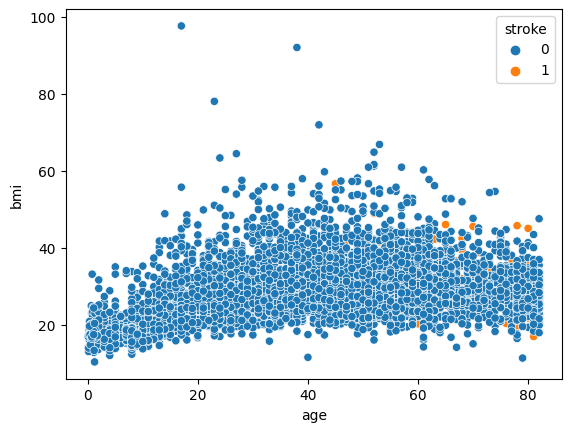

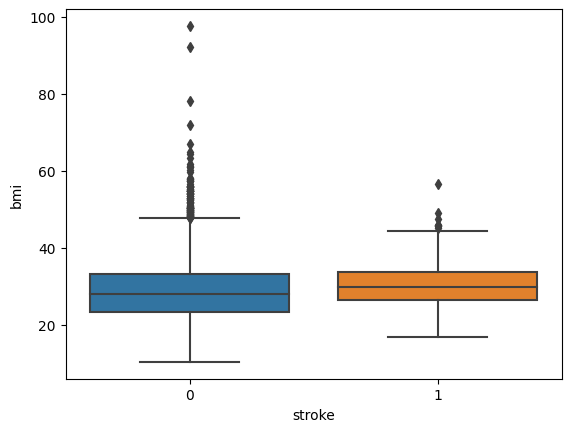

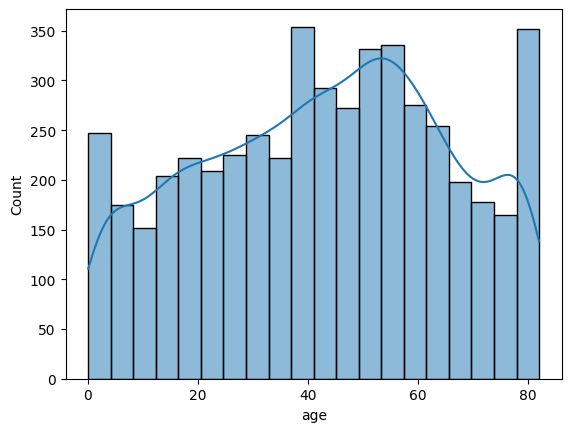

In [18]:
# Scatter plot
sns.scatterplot(data=df, x="age", y="bmi", hue="stroke")
plt.show()

# Boxplot
sns.boxplot(data=df, x="stroke", y="bmi")
plt.show()

# Histogram
sns.histplot(data=df, x="age", kde=True)
plt.show()


# Data preprocessing

1) Handling missing values - imputation (if needed).


In [19]:
# Check for missing values
print(df.isnull().sum())

# Impute missing values (if any) using mean, median, or any other technique
# df['column_name'].fillna(df['column_name'].mean(), inplace=True)

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
age_group            0
bmi_category         0
glucose_range        0
ever_smoked          0
risk_factor_count    0
surr_key             0
dtype: int64


2) Handling categorical attributes - one-hot encoding or conversion to ordinal data.

In [20]:
# One-hot encoding
categorical_columns = ["gender", "ever_married", "work_type", "residence_type", "smoking_status", "age_group", "bmi_category", "glucose_range", "ever_smoked"]
df = pd.get_dummies(df, columns=categorical_columns)
# Convert ordinal data
# age_group_mapping = {'age_group_1': 1, 'age_group_2': 2, ...}
# df['age_group'] = df['age_group'].map(age_group_mapping)


3) Normalization of numeric attributes.


In [21]:
from sklearn.preprocessing import MinMaxScaler

# Apply Min-Max normalization
scaler = MinMaxScaler()
columns_to_normalize = ["age", "avg_glucose_level", "bmi"]
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

print(df)


         id       age  hypertension  heart_disease  avg_glucose_level  \
0      9046  0.816895             0              1           0.801265   
2     31112  0.975586             0              1           0.234512   
3     60182  0.597168             0              0           0.536008   
4      1665  0.963379             1              0           0.549349   
5     56669  0.987793             0              0           0.605161   
...     ...       ...           ...            ...                ...   
5104  14180  0.157715             0              0           0.221402   
5106  44873  0.987793             0              0           0.323516   
5107  19723  0.426270             0              0           0.128658   
5108  37544  0.621582             0              0           0.513203   
5109  44679  0.536133             0              0           0.139230   

           bmi  stroke  risk_factor_count  surr_key  gender_Female  ...  \
0     0.301260       1                  4       

4) Feature selection - remove potentially redundant attributes.

In [22]:
# Import necessary libraries

from sklearn.feature_selection import SelectKBest, f_classif


# Split the data into features and target
X = df.drop(columns=["id", "stroke"])  # Excluding target variable
y = df["stroke"]

# Apply SelectKBest for feature selection
k_best = SelectKBest(f_classif, k=10)
k_best.fit(X, y)

# Get the top features
top_features = X.columns[k_best.get_support()]

print("Top 10 features:")
print(top_features)


Top 10 features:
Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'risk_factor_count', 'surr_key', 'age_group_70-79', 'age_group_80-89',
       'glucose_range_Non-diabetic', 'glucose_range_Diabetic'],
      dtype='object')


c:\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
